In [51]:
import copy

import cv2
import matplotlib.pyplot as plt
import numpy as np

IMG_PATH = 'image4.png'
img = cv2.imread(IMG_PATH, 1)
bg = cv2.imread("bg.png", 1)


class Plotter:
    def __init__(self, row, colomn):
        self.shape = (row, colomn)

    def show_img(self, order, img, title=""):
        plt.subplot(*self.shape, order)
        plt.title(title)
        plt.axis("off")
        plt.imshow(img)

    def show_plot(self, order, plot, title=""):
        plt.subplot(*self.shape, order)
        plt.title(title)
        plt.plot(plot)

    def show_multi_plot(self, order, plot, title=""):
        plt.subplot(*self.shape, order)
        plt.title(title)
        plt.plot(*plot)


def first_nonzero(lis):
    for element in lis:
        if element != 0:
            return lis.index(element)


def minus_within(num1, num2, min_):
    result = num1 - num2
    if result >= min_:
        return result
    else:
        return min_


def plus_within(num1, num2, max_):
    result = num1 + num2
    if result <= max_:
        return result
    else:
        return max_


def last_nonzero(lis):
    return first_nonzero(lis.reversed())



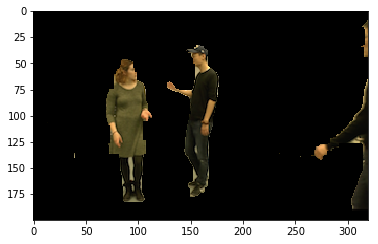

In [52]:
after_sub = cv2.imread("after_sub.png",1)
plt.imshow(after_sub)
plt.show()

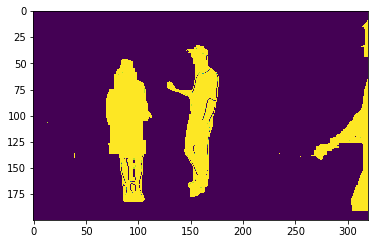

In [53]:
mask = cv2.threshold(after_sub, 1, 255, cv2.THRESH_BINARY)[1]
binary_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
plt.imshow(binary_mask)
plt.show()

In [54]:
img = binary_mask
min_height = 50
max_height = 180

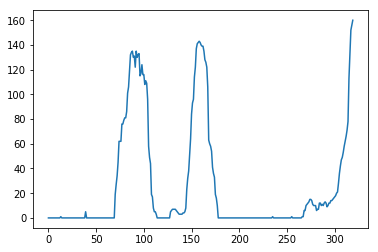

In [55]:
#
# 1: get each line's height
#

# vertical line
# amount of non zero pixels in each vertical_line
nonzero_height_in_line_list = np.count_nonzero(img, axis=0)
plt.plot(nonzero_height_in_line_list)
plt.show()

[74, 148, 309]
[106, 172]


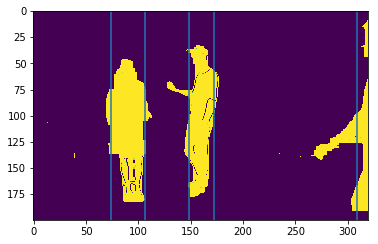

In [56]:
#
# 2: get positions of lines with enough height
#

list_of_left_side_of_body = []
list_of_right_side_of_body = []


width = len(nonzero_height_in_line_list)
for index in range(0, width):
    length = nonzero_height_in_line_list[index]

    length_before = nonzero_height_in_line_list[minus_within(
        index, 1, 0)]

    if length < max_height:
        if length_before <= min_height and length >= min_height:
            # increasing height
            list_of_left_side_of_body.append(index)
        elif length_before >= min_height and length <= min_height:
            # decreasing height
            list_of_right_side_of_body.append(index)


print(list_of_left_side_of_body)
print(list_of_right_side_of_body)

for xcoord in list_of_left_side_of_body + list_of_right_side_of_body:
    plt.axvline(xcoord)
plt.imshow(img)
plt.show()

In [77]:
#
# 3: pack each two lines into a tuple that represent a body
#


# body_sides is a list of tuples of left and right position of each body
if len(list_of_left_side_of_body) < len(list_of_right_side_of_body):
    body_sides = zip([0] + [list_of_left_side_of_body],
                     list_of_right_side_of_body)
elif len(list_of_left_side_of_body) > len(list_of_right_side_of_body):
    body_sides = zip(list_of_left_side_of_body,
                     list_of_right_side_of_body + [width])
else:
    body_sides = zip(list_of_left_side_of_body,
                     list_of_right_side_of_body)
    
# so we can use it many times with out exhausting it (as iterator)
body_sides = list(body_sides)
print(body_sides)

[(74, 106), (148, 172), (309, 320)]


In [78]:
#
# 4: find upper left and down right of each body
#

body_coordinate_list = []

for left, right in body_sides:
    # for each body
    xlist = []
    ylist = []
    # find all the coordinates of non zero pixels
    for x in range(left, right):
        # only colomns between left and right boundries
        for y in range(0, img.shape[0]):
            if img[y, x] > 0:
                xlist.append(x)
                ylist.append(y)

    xmin = min(xlist)
    xmax = max(xlist)
    ymin = min(ylist)
    ymax = max(ylist)

    body_coordinate_list.append(((xmin, ymin), (xmax, ymax)))

print(body_coordinate_list)

[((74, 47), (105, 182)), ((148, 33), (171, 177)), ((309, 10), (319, 190))]


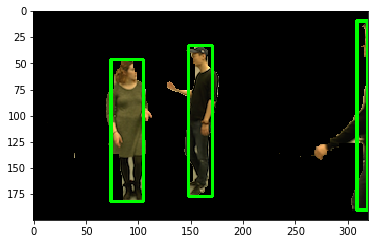

In [80]:
# draw boxes around image
copy_img = copy.copy(after_sub)
for pt1, pt2 in body_coordinate_list:
    cv2.rectangle(copy_img, pt1, pt2, (0, 255, 0), 2)

plt.imshow(copy_img)
plt.show()